In [1]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import plotly.express as px

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
params = {
    "cell_type_key": "cellType",
    "fig_fmt": "png",


    "selected_ct": ["0", "1", "2"],
    "bulk_file": "../../data/synthetic100/bulk.csv",
    "ref_annot_file": "../../data/GSE136148/pdata.tsv",
    "ref_file": "../../data/GSE136148/sc.tsv",
    
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [3]:
sadata = dv.tl.read_data(params["ref_file"])
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [4]:
print("Reading pheno data...")
pheno_df = pd.read_csv(params["ref_annot_file"], sep="\t", index_col=0)
pheno_df.index.name = None

Reading pheno data...


In [5]:
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))
len(common_cells)

3022

In [6]:
sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs[params["cell_type_key"]] = pheno_df[params["cell_type_key"]].tolist()
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
3      29
dtype: int64

In [7]:
print("Reading bulk data...")
bulk_df = pd.read_csv(params["bulk_file"], sep=",", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 8424, genes: 100


In [8]:
if params["selected_ct"] is not None and len(params["selected_ct"]) > 0:
    sadata = sadata[sadata.obs[params["cell_type_key"]].astype("str").isin(params["selected_ct"]), :].copy()

sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype("category")
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
dtype: int64

In [9]:
true_df = pd.read_csv("../../data/synthetic100/bulk_proportions.csv", index_col=0)
true_df.drop(columns="n_cells", inplace=True)

In [10]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=True)

scRNA-seq data - cells: 2993, genes: 8424
bulk RNA-seq data - samples: 100, genes: 8424


In [11]:
decon = dv.DeconV(adata, cell_type_key="cellType", sub_type_key=None, layer="counts")

Added results to: adata.uns['de']['cellType']


In [12]:
decon.filter_outliers(dropout_factor_quantile=0.9, pseudobulk_lims=(-10, 10), aggregate="max")

In [13]:
decon.init_dataset(
    weight_type=None, weight_agg="min",
    inverse_weight=False, log_weight=False, quantiles=(0, 1)
)

In [20]:
est_df = decon.deconvolute(
    model_type="poisson",
    num_epochs=50,
    lr=0.5,
    use_outlier_genes=False,
    progress_bar=True,
    signature_quantiles=(0, 0.9),
)

Sample: 0/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1873.63it/s, loss=4930.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 1/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1913.22it/s, loss=4864.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 2/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1627.73it/s, loss=4811.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 3/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1539.06it/s, loss=4833.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 4/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1688.16it/s, loss=4825.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 5/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1671.36it/s, loss=4827.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 6/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1667.24it/s, loss=4842.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 7/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1532.74it/s, loss=5259.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 8/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1629.92it/s, loss=4933.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 9/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1623.65it/s, loss=4896.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 10/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1646.27it/s, loss=4834.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 11/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1676.62it/s, loss=4894.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 12/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1671.89it/s, loss=4899.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 13/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1792.67it/s, loss=4945.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 14/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1678.88it/s, loss=4867.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 15/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1654.09it/s, loss=4805.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 16/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1558.77it/s, loss=4824.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 17/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1716.14it/s, loss=4927.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 18/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1610.74it/s, loss=4835.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 19/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1673.93it/s, loss=4893.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 20/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1767.42it/s, loss=4804.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 21/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1553.08it/s, loss=4834.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 22/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1842.13it/s, loss=5262.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 23/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1688.26it/s, loss=4931.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 24/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1663.59it/s, loss=5139.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 25/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1670.31it/s, loss=4817.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 26/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1698.42it/s, loss=4870.3, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 27/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1679.55it/s, loss=4857.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 28/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1686.10it/s, loss=4850.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 29/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1673.52it/s, loss=4962.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 30/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1687.31it/s, loss=4875.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 31/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1660.58it/s, loss=4788.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 32/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1305.92it/s, loss=5049.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 33/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1341.77it/s, loss=4839.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 34/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1719.06it/s, loss=4825.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 35/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1240.32it/s, loss=4921.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 36/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1654.73it/s, loss=4802.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 37/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1659.15it/s, loss=4851.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 38/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1652.46it/s, loss=4942.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 39/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1661.58it/s, loss=4844.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 40/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1633.00it/s, loss=4802.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 41/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1219.88it/s, loss=4932.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 42/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1567.03it/s, loss=4958.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 43/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1462.63it/s, loss=4783.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 44/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1485.73it/s, loss=5300.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 45/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1168.50it/s, loss=4963.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 46/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1831.13it/s, loss=5066.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 47/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1678.15it/s, loss=5005.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 48/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1630.15it/s, loss=5321.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 49/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1646.59it/s, loss=4818.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 50/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1629.75it/s, loss=4960.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 51/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1330.25it/s, loss=4804.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 52/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1596.66it/s, loss=5131.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 53/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1721.63it/s, loss=4807.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 54/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1753.63it/s, loss=4901.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 55/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1735.68it/s, loss=4861.3, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 56/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1036.38it/s, loss=4800.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 57/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1244.69it/s, loss=4968.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 58/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1316.91it/s, loss=4810.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 59/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1789.91it/s, loss=4837.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 60/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1785.31it/s, loss=4903.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 61/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1644.37it/s, loss=4821.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 62/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1658.19it/s, loss=4916.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 63/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1668.29it/s, loss=4889.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 64/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1681.61it/s, loss=4825.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 65/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1614.90it/s, loss=5133.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 66/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1653.20it/s, loss=5393.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 67/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1659.43it/s, loss=4791.3, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 68/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1658.13it/s, loss=4799.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 69/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1663.53it/s, loss=4888.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 70/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1611.63it/s, loss=4904.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 71/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1685.04it/s, loss=4925.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 72/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1683.09it/s, loss=5134.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 73/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1682.62it/s, loss=4996.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 74/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1668.38it/s, loss=4876.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 75/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1674.59it/s, loss=4797.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 76/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1669.81it/s, loss=5006.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 77/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1647.56it/s, loss=4845.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 78/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1442.81it/s, loss=4889.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 79/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1514.40it/s, loss=4857.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 80/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1670.44it/s, loss=4840.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 81/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1615.57it/s, loss=5041.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 82/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1604.42it/s, loss=4939.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 83/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1562.36it/s, loss=4828.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 84/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1609.48it/s, loss=5039.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 85/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1620.41it/s, loss=4876.0, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 86/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1795.38it/s, loss=4911.4, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 87/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1673.24it/s, loss=4827.8, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 88/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1660.03it/s, loss=4860.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 89/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1607.83it/s, loss=4982.6, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 90/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1635.12it/s, loss=4843.7, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 91/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1606.37it/s, loss=4826.1, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 92/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1674.64it/s, loss=4944.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 93/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1681.49it/s, loss=4997.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 94/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1669.26it/s, loss=4840.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 95/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1631.09it/s, loss=5308.2, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 96/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1773.78it/s, loss=5093.3, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 97/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1677.68it/s, loss=5381.9, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 98/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1613.73it/s, loss=4875.5, p=0.33 0.33 0.33, lib_size=1648.7]


Sample: 99/100 | Using 5378 genes (63.8%)


100%|██████████| 50/50 [00:00<00:00, 1617.57it/s, loss=4807.5, p=0.33 0.33 0.33, lib_size=1648.7]


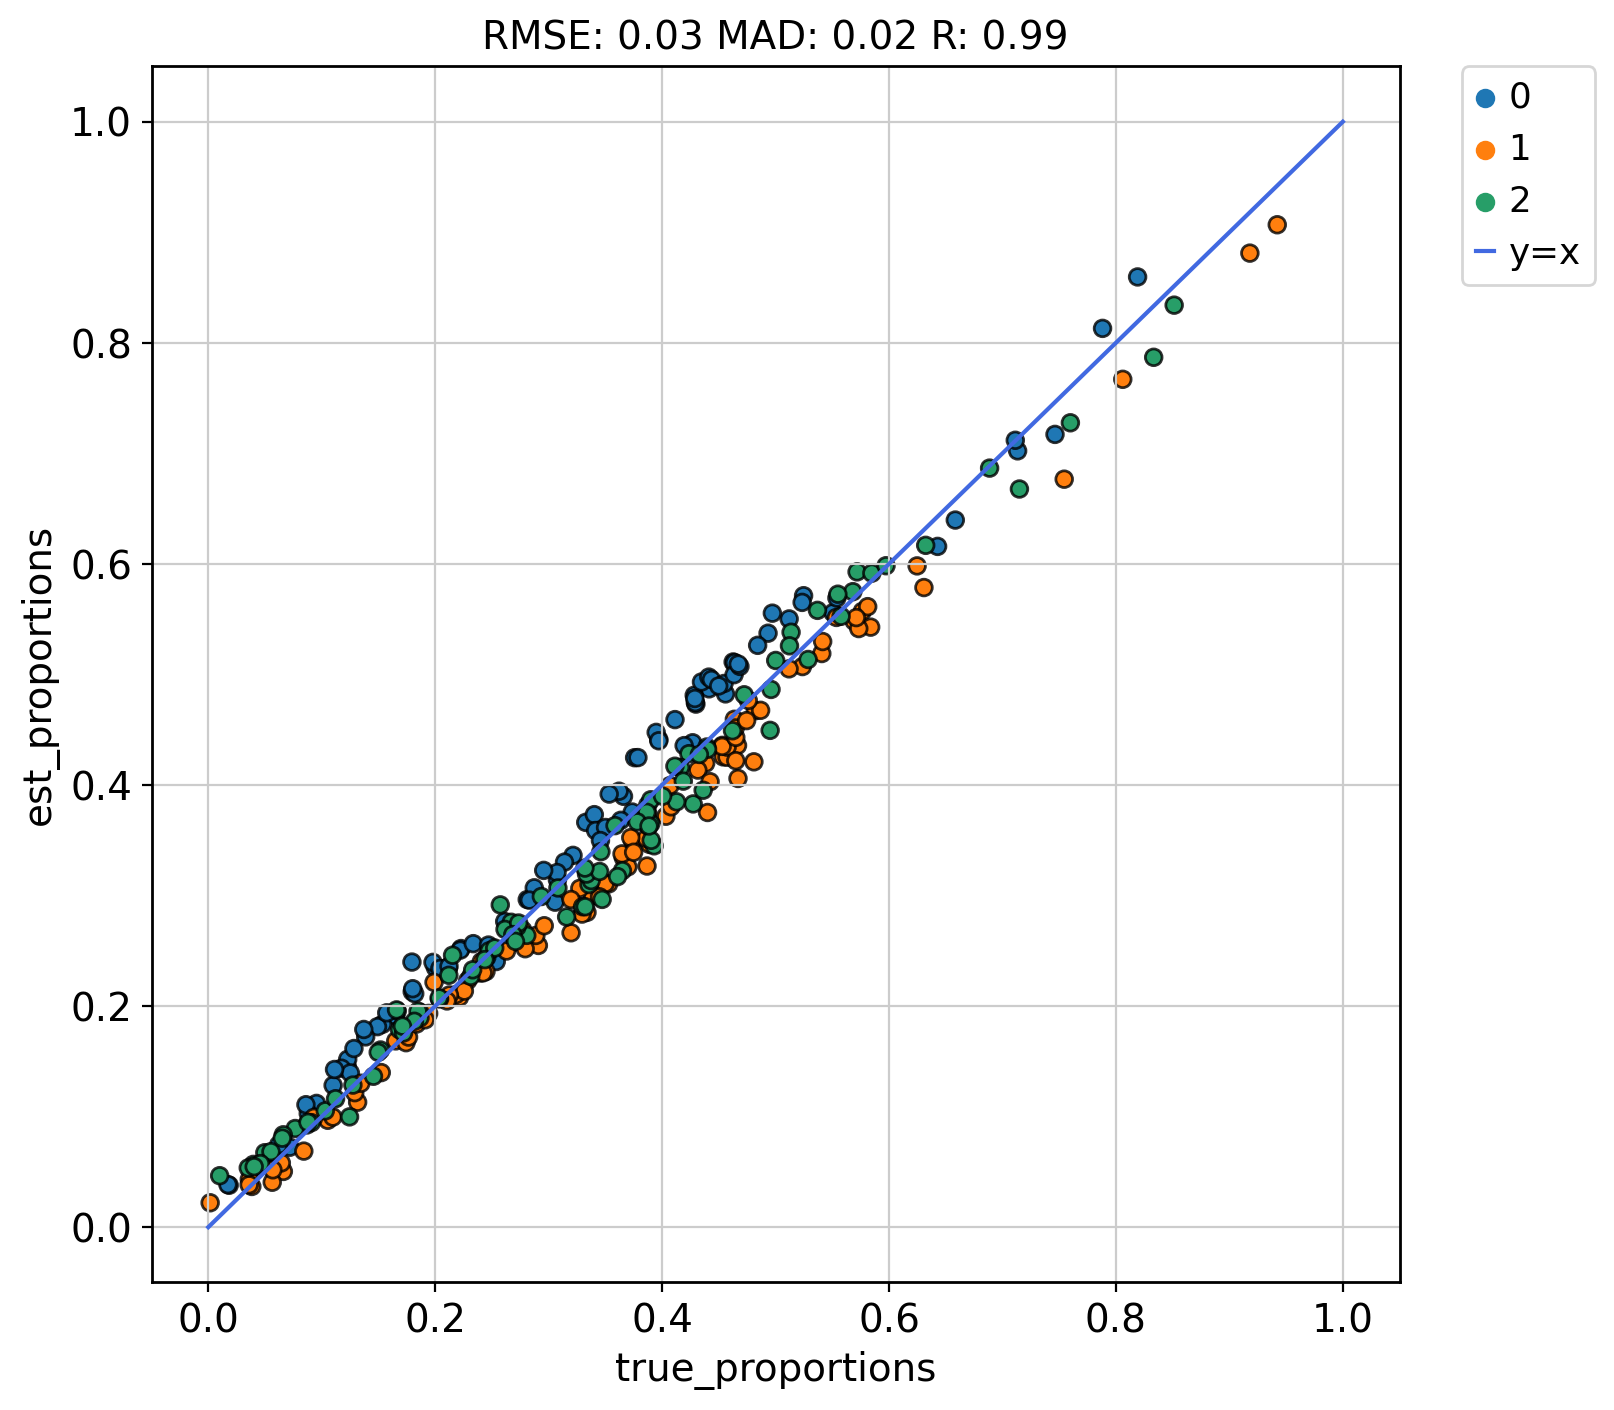

In [21]:
true_df = pd.read_csv("../../data/synthetic100/bulk_proportions.csv", index_col=0)
true_df.drop(columns="n_cells", inplace=True)
est_df.reset_index(drop=True, inplace=True)
dv.pl.scatter_check(true_df, est_df)